# Quantum Decision Trees

PCA-reduced data shape: (2880, 2)
Training Accuracy: 89.97%
Testing Accuracy: 90.10%


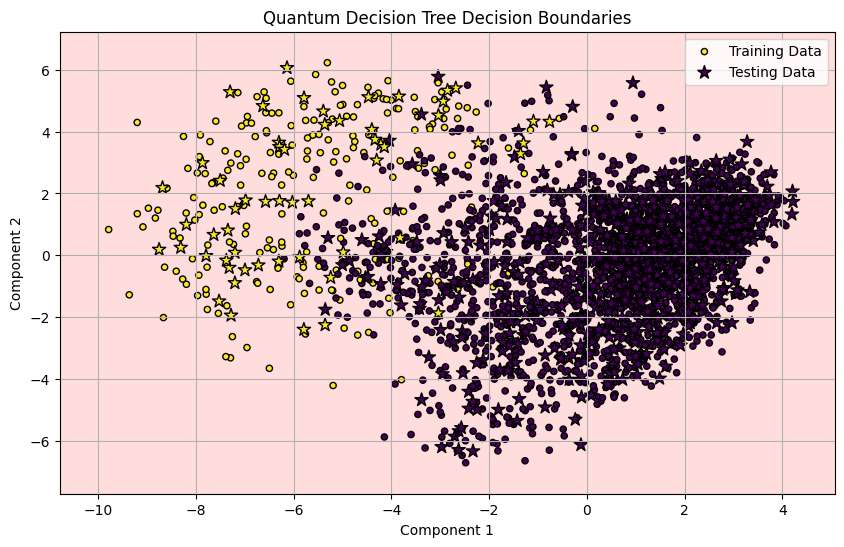

In [1]:
import os
import numpy as np
import pennylane as qml
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For progress bars
from collections import deque


###############################################################################
# 1. Nepali MNIST Dataset
###############################################################################
class NepaliMNISTDataset(Dataset):
    """
    Custom dataset for Nepali numerals. Assumes root directory structure:
      root_dir/
      ├── 0/
      │   ├── image1.png
      │   └── ...
      ├── 1/
      │   ├── image1.png
      │   └── ...
      └── 9/
          ├── image1.png
          └── ...
    """
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.data_paths = []
        self.labels = []

        # Scanning directory for digit folders
        for label_str in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label_str)
            if not os.path.isdir(label_path):
                continue
            try:
                label = int(label_str)
            except ValueError:
                continue  # Skip non-integer directory names
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    self.data_paths.append(os.path.join(label_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        img_path = self.data_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('L')  # ensure grayscale
        if self.transform:
            img = self.transform(img)
        return img, label


###############################################################################
# 2. Data Loading and Preprocessing
###############################################################################
def load_nepali_data(root_dir, batch_size=32):
    """
    Loads the Nepali MNIST dataset from the specified root directory.

    Args:
        root_dir (str): Path to the root directory containing digit folders.
        batch_size (int): Number of samples per batch.

    Returns:
        DataLoader: PyTorch DataLoader for the dataset.
    """
    # Basic transforms to resize to 28x28 and convert to tensor
    transform_pipeline = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    dataset = NepaliMNISTDataset(root_dir, transform=transform_pipeline)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

def preprocess_data(loader, n_components=2):
    """
    Flattens images to vectors and applies PCA to reduce dimensionality.

    Args:
        loader (DataLoader): PyTorch DataLoader for the dataset.
        n_components (int): Number of PCA components.

    Returns:
        tuple: (PCA-reduced data, labels)
    """
    flattened_data = []
    labels = []
    for images, lbls in loader:
        # Ensure tensors are on CPU before converting to NumPy
        images = images.cpu()
        flattened_batch = images.view(images.size(0), -1).numpy()
        flattened_data.append(flattened_batch)
        labels.append(lbls.numpy())

    data_array = np.concatenate(flattened_data, axis=0)
    labels_array = np.concatenate(labels, axis=0)
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_array)
    return data_pca, labels_array  # shape: (num_samples, n_components), (num_samples,)


###############################################################################
# 3. Quantum Decision Tree Components
###############################################################################

# Define the number of qubits based on the PCA components
n_components = 2  # Number of features after PCA
n_qubits = 2       # Must be >= ceil(log2(n_components)) to accommodate all components

# Initialize PennyLane device for the quantum decision node
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_decision_node(params, features):
    """
    Quantum circuit acting as a decision node in the decision tree.

    Args:
        params (list or np.ndarray): List of rotation parameters.
        features (list or np.ndarray): Input feature vector.

    Returns:
        float: Probability of taking the left branch.
    """
    for i in range(n_qubits):
        qml.RY(params[i] * features[i], wires=i)  # Rotate each qubit based on feature

    # Entangle qubits
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Measurement: Expectation value of PauliZ on the first qubit
    return qml.expval(qml.PauliZ(wires=0))


# Define the QNode
@qml.qnode(dev)
def decision_circuit(params, features):
    """
    PennyLane QNode that runs the quantum decision circuit.

    Args:
        params (list or np.ndarray): List of rotation parameters.
        features (list or np.ndarray): Input feature vector.

    Returns:
        float: Expectation value indicating the decision.
    """
    return quantum_decision_node(params, features)


###############################################################################
# 4. Quantum Decision Tree Class
###############################################################################

class QuantumDecisionTree:
    """
    Hybrid Quantum-Classical Decision Tree for classification.

    Each internal node contains a quantum circuit that determines the split based on input features.
    """
    def __init__(self, max_depth=3, min_samples_split=2, verbose=False):
        """
        Initializes the Quantum Decision Tree.

        Args:
            max_depth (int): Maximum depth of the tree.
            min_samples_split (int): Minimum number of samples required to split a node.
            verbose (bool): Flag to enable/disable debug print statements.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.verbose = verbose
        self.root = None

    class Node:
        """
        Represents a node in the decision tree.
        """
        def __init__(self, depth=0):
            self.depth = depth
            self.is_leaf = False
            self.prediction = None
            self.left = None
            self.right = None
            self.params = None  # Parameters for the quantum circuit

    def fit(self, X, y):
        """
        Fits the decision tree to the data.

        Args:
            X (np.ndarray): Feature matrix.
            y (np.ndarray): Labels.
        """
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        node = self.Node(depth=depth)

        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # Stopping conditions
        if (depth >= self.max_depth or num_samples < self.min_samples_split or num_labels == 1):
            node.is_leaf = True
            node.prediction = self._majority_vote(y)
            if self.verbose:
                print(f"Creating leaf node at depth {depth} with prediction {node.prediction}")
            return node

        # Initialize quantum circuit parameters
        params = 0.01 * np.random.randn(n_qubits)
        node.params = params

        # Compute decision using quantum circuit
        decisions = []
        for sample in X:
            decision = decision_circuit(params, sample)
            # Convert expectation value to probability
            prob = (decision + 1) / 2  # Normalize from [-1,1] to [0,1]
            decisions.append(prob)

        decisions = np.array(decisions)
        left_indices = decisions >= 0.5
        right_indices = decisions < 0.5

        if len(np.unique(left_indices)) == 1 or len(np.unique(right_indices)) == 1:
            # If no effective split, make it a leaf
            node.is_leaf = True
            node.prediction = self._majority_vote(y)
            if self.verbose:
                print(f"Creating leaf node at depth {depth} due to ineffective split with prediction {node.prediction}")
            return node

        # Split the dataset
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        if self.verbose:
            print(f"Splitting node at depth {depth}: left={len(y_left)}, right={len(y_right)}")

        # Recursively build left and right subtrees
        node.left = self._build_tree(X_left, y_left, depth + 1)
        node.right = self._build_tree(X_right, y_right, depth + 1)

        return node

    def _majority_vote(self, y):
        """
        Determines the majority class in the labels.

        Args:
            y (np.ndarray): Labels.

        Returns:
            int: Majority class label.
        """
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def predict(self, X):
        """
        Predicts labels for given samples.

        Args:
            X (np.ndarray): Feature matrix.

        Returns:
            list: Predicted labels.
        """
        return [self._traverse_tree(x, self.root) for x in X]

    def _traverse_tree(self, x, node):
        if node.is_leaf:
            return node.prediction
        decision = decision_circuit(node.params, x)
        prob = (decision + 1) / 2
        if prob >= 0.5:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def evaluate(self, X, y):
        """
        Evaluates the decision tree's accuracy on the provided data.

        Args:
            X (np.ndarray): Feature matrix.
            y (np.ndarray): True labels.

        Returns:
            float: Accuracy score.
        """
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        
        return accuracy

###############################################################################
# 5. Training and Evaluation
###############################################################################

def train_evaluate_qdt(X_train, y_train, X_test, y_test, max_depth=3, min_samples_split=2, verbose=False):
    """
    Trains and evaluates the Quantum Decision Tree.

    Args:
        X_train (np.ndarray): Training feature matrix.
        y_train (np.ndarray): Training labels.
        X_test (np.ndarray): Testing feature matrix.
        y_test (np.ndarray): Testing labels.
        max_depth (int): Maximum depth of the tree.
        min_samples_split (int): Minimum number of samples required to split a node.
        verbose (bool): Flag to enable/disable debug print statements.

    Returns:
        QuantumDecisionTree: Trained decision tree.
    """
    qdt = QuantumDecisionTree(max_depth=max_depth, min_samples_split=min_samples_split, verbose=verbose)
    qdt.fit(X_train, y_train)

    # Evaluate on training data
    train_accuracy = qdt.evaluate(X_train, y_train)
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

    # Evaluate on testing data
    test_accuracy = qdt.evaluate(X_test, y_test)
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

    return qdt

###############################################################################
# 6. Main Function to Demonstrate Quantum Decision Tree
###############################################################################

def main():
    """
    Main function to execute the Quantum Decision Tree training and evaluation.
    """
    # Update the root_dir to your dataset path
    root_dir = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # <-- Replace with your actual dataset path
    loader = load_nepali_data(root_dir, batch_size=32)

    # Preprocess data
    data_pca, labels = preprocess_data(loader, n_components=n_components)
    print("PCA-reduced data shape:", data_pca.shape)

    # Convert data to torch tensors
    data_pca_tensor = torch.tensor(data_pca, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # Split into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        data_pca_tensor.numpy(),
        labels_tensor.numpy(),
        test_size=0.2,
        random_state=42,
        stratify=labels_tensor.numpy()
    )

    # For simplicity, perform binary classification (e.g., class 0 vs others)
    # Modify as needed for multi-class classification
    binary_threshold = 0  # Change this to select a different class as positive
    y_train_binary = (y_train == binary_threshold).astype(int)
    y_test_binary = (y_test == binary_threshold).astype(int)

    # Train and evaluate Quantum Decision Tree
    max_depth = 3
    min_samples_split = 10
    verbose = False  # Set to True to enable detailed logging

    qdt = train_evaluate_qdt(
        X_train, y_train_binary,
        X_test, y_test_binary,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        verbose=verbose
    )

    # Visualize Decision Boundaries (only works for 2D PCA)
    visualize_decision_boundaries(qdt, X_train, y_train_binary, X_test, y_test_binary)


###############################################################################
# 7. Visualization of Decision Boundaries
###############################################################################

def visualize_decision_boundaries(qdt, X_train, y_train, X_test, y_test):
    """
    Visualizes the decision boundaries of the Quantum Decision Tree.

    Args:
        qdt (QuantumDecisionTree): Trained decision tree.
        X_train (np.ndarray): Training feature matrix.
        y_train (np.ndarray): Training labels.
        X_test (np.ndarray): Testing feature matrix.
        y_test (np.ndarray): Testing labels.
    """
    # Define bounds of the domain
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

    # Define the meshgrid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict on the grid
    Z = qdt.predict(grid)
    Z = np.array(Z).reshape(xx.shape)

    # Plot the contour and training examples
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, levels=[-0.1, 0.5, 1.1], colors=['#FFAAAA', '#AAAAFF'])
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k', label='Training Data')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=100, marker='*', edgecolor='k', label='Testing Data')
    plt.title("Quantum Decision Tree Decision Boundaries")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()


###############################################################################
# 8. Execute the Main Function
###############################################################################

if __name__ == "__main__":
    main()

